In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/parkinsons-disease-classification/pd_speech_features.csv


# Part 1: Method-ML Algorithams

In [2]:
#ML Librarires 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import seaborn as sns
import missingno as msno
import plotly.express as px
import  matplotlib.pyplot as plt


plt.style.use('seaborn')
%matplotlib inline

# Data Read, Data Visualization,EDA Analysis,Data Pre-Processing,Data Splitting

In [3]:
#Data Read
df=pd.read_csv('../input/parkinsons-disease-classification/pd_speech_features.csv',index_col=0, delimiter=',', skiprows=1)


In [4]:
df

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
id,,,,,,,,,,,,,,,,,,,,,
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,0.000044,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0,0.80903,0.56355,0.28385,417,416,0.004627,0.000052,0.00064,0.000003,...,3.0706,3.0190,3.1212,2.4921,3.5844,3.5400,3.3805,3.2003,6.8671,0
250,0,0.16084,0.56499,0.59194,415,413,0.004550,0.000220,0.00143,0.000006,...,1.9704,1.7451,1.8277,2.4976,5.2981,4.2616,6.3042,10.9058,28.4170,0
251,0,0.88389,0.72335,0.46815,381,380,0.005069,0.000103,0.00076,0.000004,...,51.5607,44.4641,26.1586,6.3076,2.8601,2.5361,3.5377,3.3545,5.0424,0


In [5]:
df = df.loc[:,~df.columns.duplicated()]

In [6]:
df=df.sample(frac=1).reset_index(drop=True)

In [7]:
df.apply(lambda x: sum(x.isnull()),axis=0)

gender                       0
PPE                          0
DFA                          0
RPDE                         0
numPulses                    0
                            ..
tqwt_kurtosisValue_dec_33    0
tqwt_kurtosisValue_dec_34    0
tqwt_kurtosisValue_dec_35    0
tqwt_kurtosisValue_dec_36    0
class                        0
Length: 754, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 754 entries, gender to class
dtypes: float64(749), int64(5)
memory usage: 4.3 MB


In [9]:
df.describe()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,...,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,...,26.237251,22.840337,18.587888,13.872018,12.218953,12.375335,14.799230,14.751559,31.481110,0.746032
std,0.500079,0.169294,0.069718,0.137442,99.219059,99.402499,0.001826,0.000728,0.002628,2.290134e-05,...,42.220693,32.626464,25.537464,20.046029,17.783642,16.341665,15.722502,14.432979,34.230991,0.435568
min,0.000000,0.041551,0.543500,0.154300,2.000000,1.000000,0.002107,0.000011,0.000210,6.860000e-07,...,1.509800,1.531700,1.582900,1.747200,1.789500,1.628700,1.861700,1.955900,2.364000,0.000000
25%,0.000000,0.762833,0.647053,0.386537,251.000000,250.000000,0.005003,0.000049,0.000970,5.260000e-06,...,2.408675,3.452800,3.354825,3.077450,2.937025,3.114375,3.665925,3.741275,3.948750,0.000000
50%,1.000000,0.809655,0.700525,0.484355,317.000000,316.000000,0.006048,0.000077,0.001495,9.530000e-06,...,5.586300,7.062750,6.077400,4.770850,4.300450,4.741450,6.725700,7.334250,10.637250,1.000000
75%,1.000000,0.834315,0.754985,0.586515,384.250000,383.250000,0.007528,0.000171,0.002520,1.832500e-05,...,28.958075,29.830850,21.944050,13.188000,10.876150,12.201325,21.922050,22.495175,61.125325,1.000000
max,1.000000,0.907660,0.852640,0.871230,907.000000,905.000000,0.012966,0.003483,0.027750,2.564800e-04,...,239.788800,203.311300,121.542900,102.207000,85.571700,73.532200,62.007300,57.544300,156.423700,1.000000


In [10]:
#Plotting data 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px

<AxesSubplot:xlabel='class', ylabel='count'>

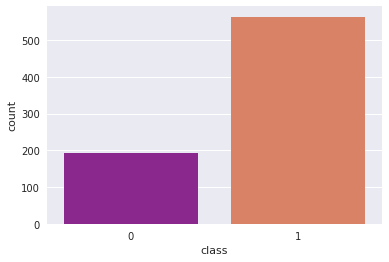

In [11]:
#checking the target variable countplot
sns.countplot(data=df,x = 'class',palette='plasma')

Imbalanced data distribution for target class.

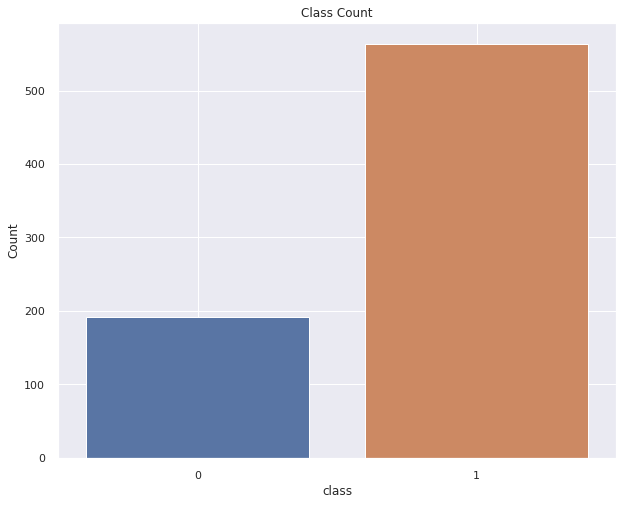

In [12]:
sns.set(rc={'figure.figsize':(10,8)})
fig = sns.countplot(x = "class" , data = df)
plt.xlabel("class")
plt.ylabel("Count")
plt.title("Class Count")
plt.grid(True)
plt.show(fig)

In [13]:

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
df.columns

Index(['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       'locAbsJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=754)

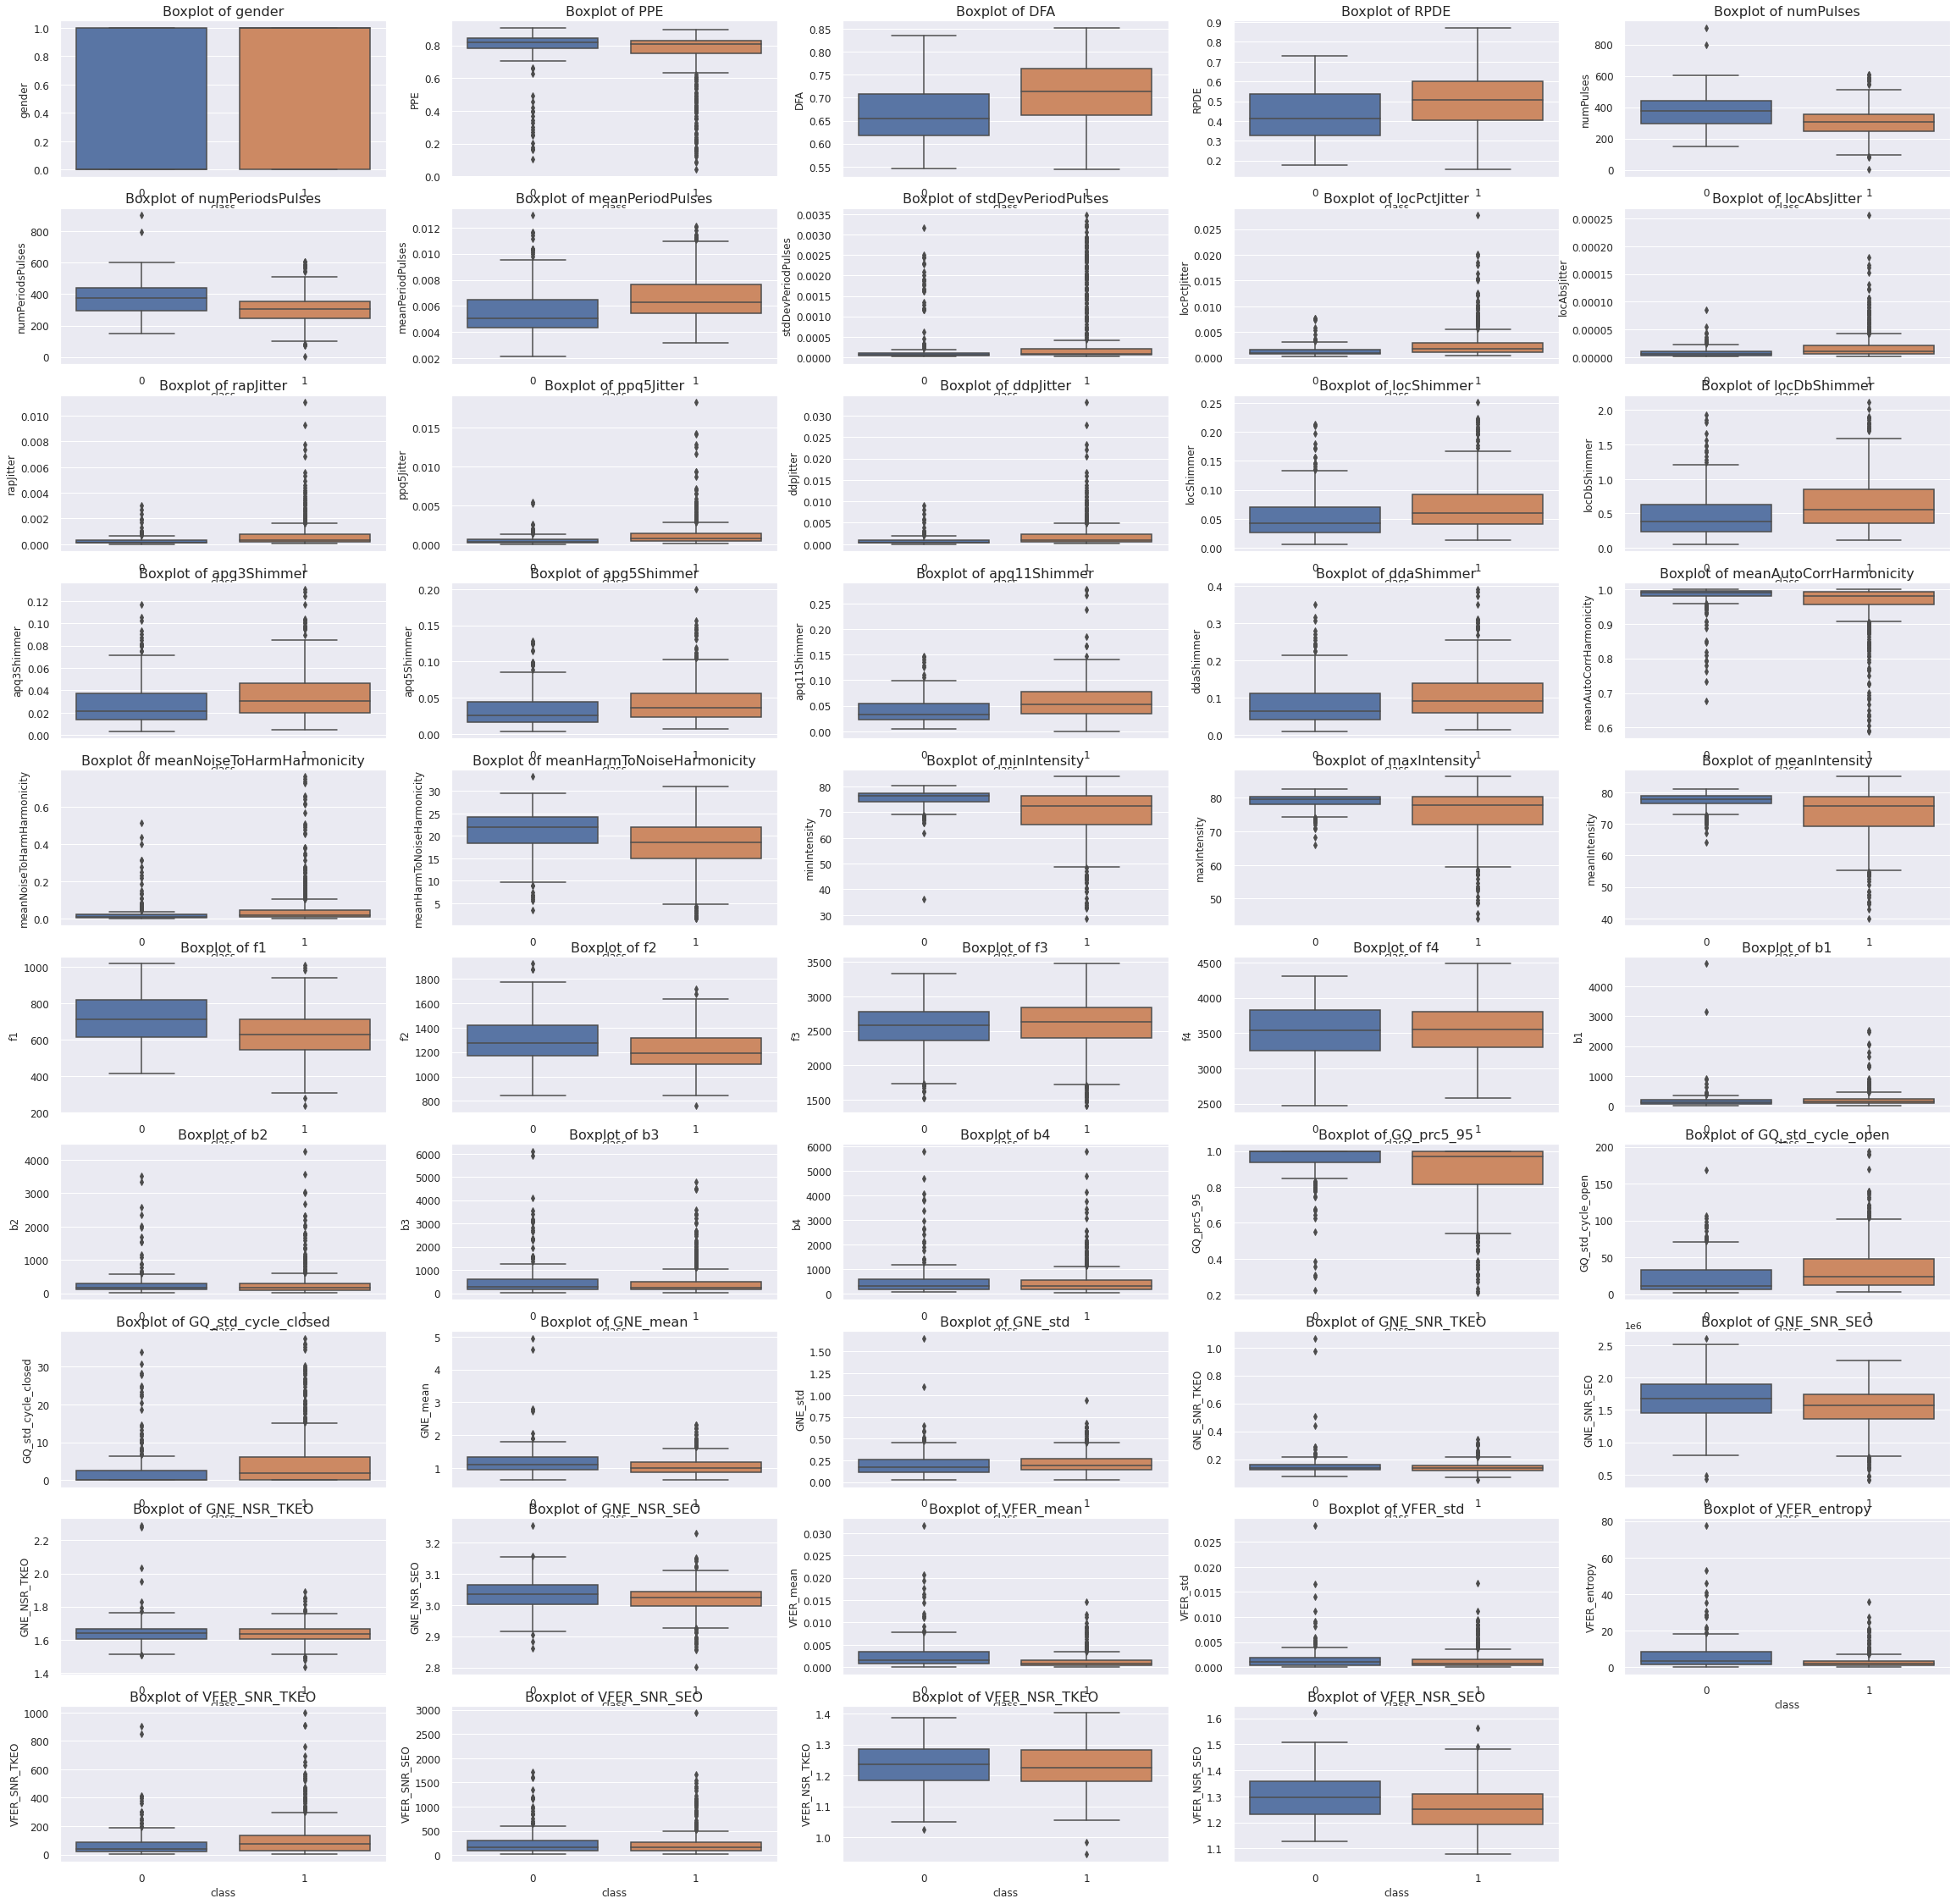

In [15]:
#Box Plotting All features distribution corresponding Target column
i=1
plt.figure(figsize=(40,40))
for c in df.columns[:49]:
    plt.subplot(10,5,i)
    plt.title(f"Boxplot of {c}",fontsize=16)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    sns.boxplot(y=df[c],x=df['class'])
    i+=1
plt.show()

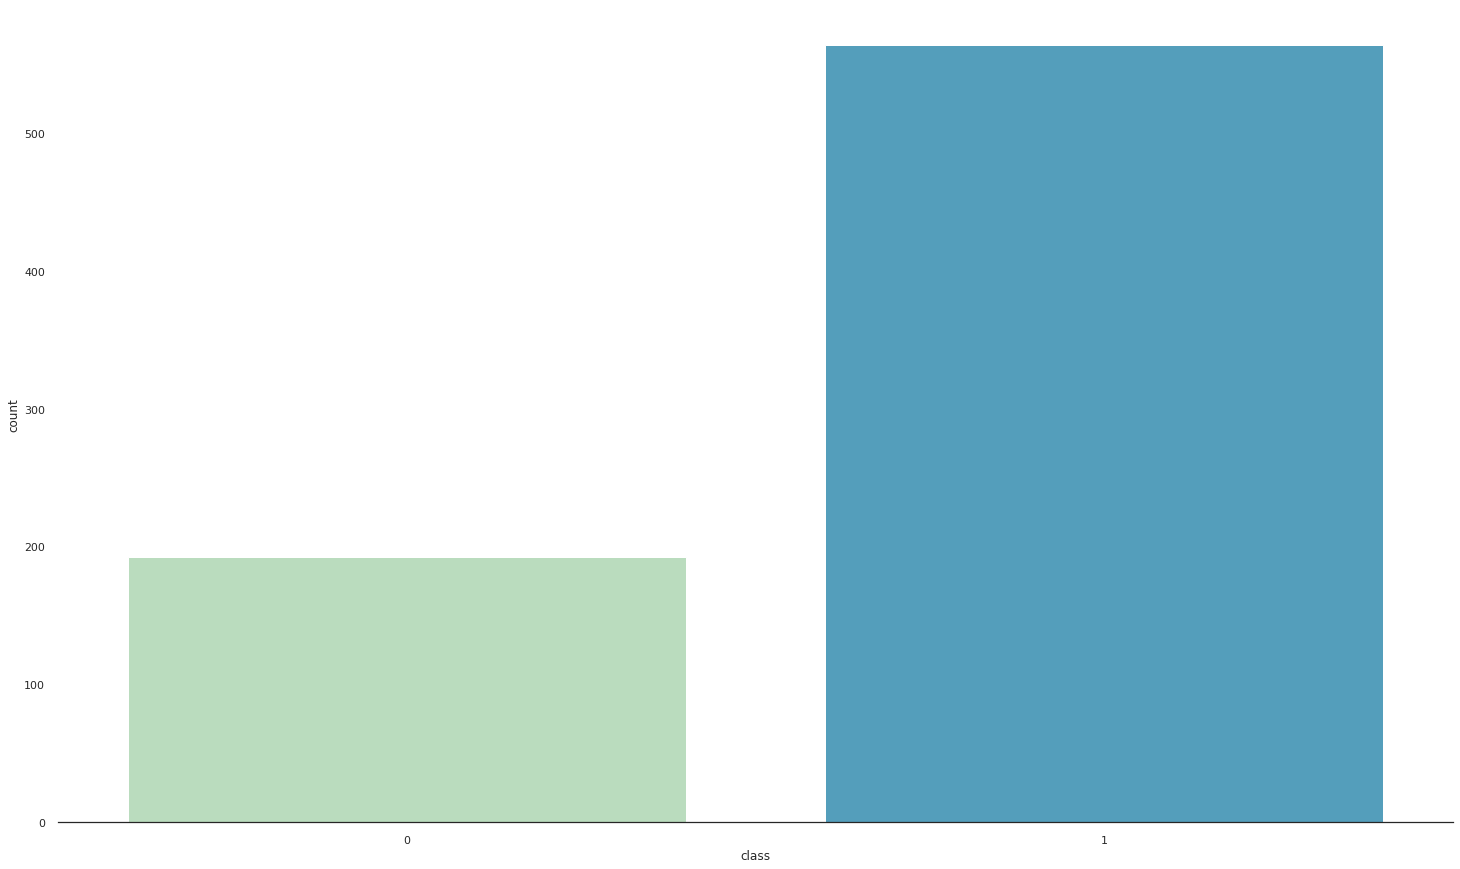

In [16]:
#checking the target variable countplot

plt.figure(figsize=(25,15))
sns.set_style('white')
sns.countplot(x='class', data = df, palette='GnBu')
sns.despine(left=True)

N.B. = I prefer to use models without outlier & imbalanced treatment, in many cases it can improve the model performance. But it also leads to change of information which might alter real/practical situations

Data Splitting

In [17]:
dataX=df.drop('class',axis=1)
dataY=df['class']

In [18]:
X_train,X_test,y_train,y_test=train_test_split(dataX,dataY,test_size=0.15,random_state=42)

In [19]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (642, 753)
X_test (114, 753)
y_train (642,)
y_test (114,)


In [20]:
dims = X_train.shape[1]
print(dims, 'dims')

753 dims


In [21]:
dims = X_test.shape[1]
print(dims, 'dims')

753 dims


In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
def plot_roc_(false_positive_rate,true_positive_rate,roc_auc):
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [24]:
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc


# Part 1 for ML Algorithms

With PCA Analysis

In [25]:
from sklearn.decomposition import PCA
pca=PCA(n_components=50)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

In [26]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (642, 50)
X_test (114, 50)
y_train (642,)
y_test (114,)


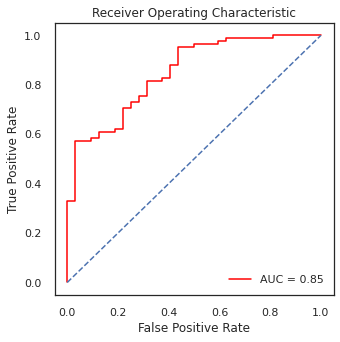

Accurancy Oranı : 0.8070175438596491
Logistic TRAIN score with  0.9003115264797508
Logistic TEST score with  0.8070175438596491

[[18 14]
 [ 8 74]]


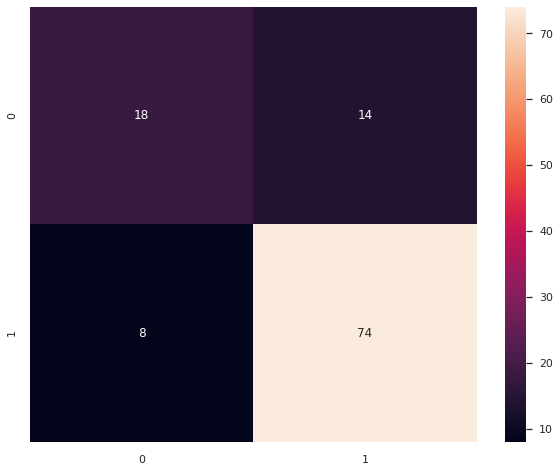

In [27]:
from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(C=0.1,penalty='l2',random_state=42)
lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)


y_proba=lr.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plot_roc_(false_positive_rate,true_positive_rate,roc_auc)


from sklearn.metrics import r2_score,accuracy_score

#print('Hata Oranı :',r2_score(y_test,y_pred))
print('Accurancy Oranı :',accuracy_score(y_test, y_pred))
print("Logistic TRAIN score with ",format(lr.score(X_train, y_train)))
print("Logistic TEST score with ",format(lr.score(X_test, y_test)))
print()

cm=confusion_matrix(y_test,y_pred)
print(cm)
sns.heatmap(cm,annot=True)
plt.show()

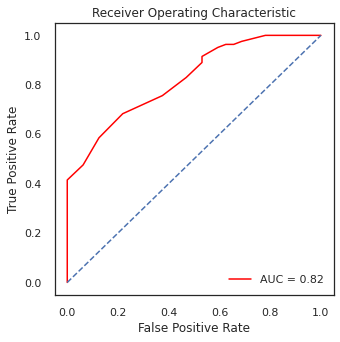

Accurancy Oranı : 0.7982456140350878
KNN TRAIN score with  0.8426791277258567
KNN TEST score with  0.7982456140350878

[[13 19]
 [ 4 78]]


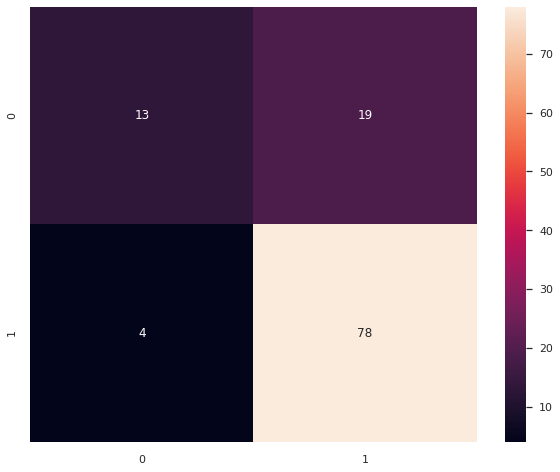

In [28]:
knn=KNeighborsClassifier(n_jobs=2, n_neighbors=22)
knn.fit(X_train,y_train)

y_pred=knn.predict(X_test)

y_proba=knn.predict_proba(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,y_proba[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
plot_roc_(false_positive_rate,true_positive_rate,roc_auc)

from sklearn.metrics import r2_score,accuracy_score

print('Accurancy Oranı :',accuracy_score(y_test, y_pred))
print("KNN TRAIN score with ",format(knn.score(X_train, y_train)))
print("KNN TEST score with ",format(knn.score(X_test, y_test)))
print()

cm=confusion_matrix(y_test,y_pred)
print(cm)
sns.heatmap(cm,annot=True)
plt.show()

#  Withou PCA Analysis & Using Machine Learning Algorithms; Part 2 for ML Algorithms

In [29]:
X_train,X_test,y_train,y_test=train_test_split(dataX,dataY,test_size=0.15,random_state=42)

In [30]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [31]:
# Fitting Logistic Regression To the training set 
from sklearn.linear_model import LogisticRegression   
  
classifier = LogisticRegression(penalty='l2',solver='lbfgs',class_weight='balanced', max_iter=1000,random_state = 42) 
classifier.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [32]:
y_pred = classifier.predict(X_test)


In [33]:
# making confusion matrix between 
#  test set of Y and predicted value. 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred) 
print (cm)

[[22 10]
 [12 70]]


In [34]:
from sklearn.metrics import classification_report,accuracy_score
print(classification_report(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred)*100)

print(y_pred)

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        32
           1       0.88      0.85      0.86        82

    accuracy                           0.81       114
   macro avg       0.76      0.77      0.77       114
weighted avg       0.81      0.81      0.81       114

Accuracy: 80.7017543859649
[0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 1
 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1
 1 1 1]


In [35]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [36]:
names = [ "MLP-Neural Net", "Naive Bayes", "QDA"]

classifiers = [
    MLPClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [37]:
from sklearn.model_selection import cross_val_score

# iterate over classifiers
results = {}
for name, clf in zip(names, classifiers):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    results[name] = scores

/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [38]:
for name, scores in results.items():
    print("%20s | Accuracy: %0.2f%% (+/- %0.2f%%)" % (name, 100*scores.mean(), 100*scores.std() * 2))

      MLP-Neural Net | Accuracy: 87.84% (+/- 4.33%)
         Naive Bayes | Accuracy: 75.41% (+/- 10.97%)
                 QDA | Accuracy: 64.49% (+/- 14.94%)


In [39]:
from sklearn.model_selection import GridSearchCV

clf = SVC(kernel="linear")

# prepare a range of values to test
param_grid = [
  {'C': [.01, .1, 1, 10], 'kernel': ['linear']},
 ]

grid = GridSearchCV(estimator=clf, param_grid=param_grid)
grid.fit(X_train, y_train)
print(grid)

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid=[{'C': [0.01, 0.1, 1, 10], 'kernel': ['linear']}])


In [40]:
# summarize the results of the grid search
print("Best score: %0.2f%%" % (100*grid.best_score_))
print("Best estimator for parameter C: %f" % (grid.best_estimator_.C))

Best score: 84.11%
Best estimator for parameter C: 0.010000


# Part 3 for Algorithms

In [41]:
seed = 42

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier,\
                            BaggingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline

In [42]:
# split the data into train and test
def split_data(X, Y, seed=42, train_size=0.8):
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=train_size, random_state = seed, stratify=Y)
    xtrain, xtest = preprocess(xtrain, xtest)
    return (xtrain, xtest, ytrain, ytest)

# preprocess the data for training
def preprocess(x1, x2=None):
    sc = StandardScaler()
    x1 = pd.DataFrame(sc.fit_transform(x1), columns=x1.columns)
    if x2 is not None:
        x2 = pd.DataFrame(sc.transform(x2), columns=x2.columns)
        return (x1,x2)
    return x1

# for model evaluation and training
def eval_model(model, X, Y, seed=1):
    xtrain, xtest, ytrain, ytest = split_data(X, Y)
    model.fit(xtrain, ytrain)
    
    trainpred = model.predict(xtrain)
    trainpred_prob = model.predict_proba(xtrain)
    testpred = model.predict(xtest)
    testpred_prob = model.predict_proba(xtest)
    
    print("Train ROC AUC : %.4f"%roc_auc_score(ytrain, trainpred_prob, multi_class='ovr'))
    print("\nTrain classification report\n",classification_report(ytrain, trainpred))
    
    ### make a bar chart for displaying the wrong classification of one class coming in which other class
    
    print("\nTest ROC AUC : %.4f"%roc_auc_score(ytest, testpred_prob, multi_class='ovr'))
    print("\nTest classification report\n",classification_report(ytest, testpred))
    
def plot_importance(columns, importance):
    plt.bar(columns, importance)
    plt.show()

In [43]:
#Feature Extraction, Importance & Splitting

Y= df['class']

X = df.drop(['class'],axis = 1)

In [44]:
X_sc = preprocess(X)

# Creating array of models

In [45]:
model_logr = LogisticRegression(random_state=seed,n_jobs=-1)
model_nb = GaussianNB()
model_dt = DecisionTreeClassifier(random_state=seed)
model_dt_bag = BaggingClassifier(model_dt, random_state=seed, n_jobs=-1)
model_ada = AdaBoostClassifier(random_state=seed)
model_gbc = GradientBoostingClassifier(random_state=seed)
model_rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
model_xgb = XGBClassifier(random_state=seed)
model_lgbm = LGBMClassifier(random_state=seed, n_jobs=-1)
model_knn = KNeighborsClassifier(n_jobs=-1)

In [46]:
models = []
models.append(('LR',model_logr))
models.append(('NB',model_nb))
models.append(('DT',model_dt))
models.append(('Bag',model_dt_bag))
models.append(('Ada',model_ada))
models.append(('GBC',model_gbc))
models.append(('RF',model_rf))
models.append(('XGB',model_xgb))
models.append(('LGBM',model_lgbm))
models.append(('KNN',model_knn))

# Running the algorithms

In [47]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

results = []
names = []

for name, model in models:
    scores = cross_val_score(model, X_sc, Y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    accuracy = scores.mean()
    std = scores.std()
    print(f"{name} : Mean ROC {accuracy} STD:({std})")
    results.append(scores)
    names.append(name)

LR : Mean ROC 0.8320965817808352 STD:(0.014530733847982718)
NB : Mean ROC 0.792266450424797 STD:(0.026872331112173683)
DT : Mean ROC 0.8163773766173087 STD:(0.02637245749524643)
Bag : Mean ROC 0.8451708281041934 STD:(0.02611556509101956)
Ada : Mean ROC 0.8786151428058255 STD:(0.018981909043535816)
GBC : Mean ROC 0.8923782983092139 STD:(0.020204570703542812)
RF : Mean ROC 0.8749052318876978 STD:(0.013563072587700925)
XGB : Mean ROC 0.8924263039592377 STD:(0.021287297239478305)


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


LGBM : Mean ROC 0.8971953521715605 STD:(0.024445430599451284)
KNN : Mean ROC 0.8533784706616213 STD:(0.013836853195549668)


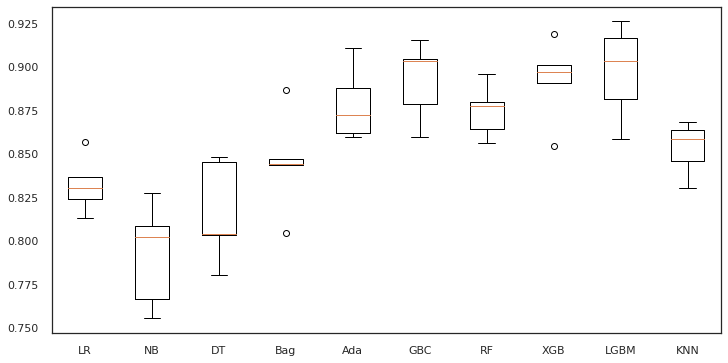

In [48]:
fig, ax = plt.subplots(figsize=(12,6))
ax.boxplot(results)
ax.set_xticklabels(names)
plt.show()

 # Using Deep Neural Networks ; Part4

In [49]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(642, 753) (642,)
(114, 753) (114,)


In [50]:
#Keras
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import Dense, Dropout , BatchNormalization
from keras.utils import np_utils
from keras.optimizers import RMSprop, Adam

#tf 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [51]:
model = Sequential()
model.add(Dense(64,input_dim=X_train.shape[1],activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                48256     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               3

In [53]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [54]:
fBestModel = 'best_model.h5' 
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=100, 
          batch_size=62, verbose=True, callbacks=[best_model, early_stop])

Epoch 1/100
11/11 [==============================] - 4s 95ms/step - loss: 0.9839 - accuracy: 0.5400 - val_loss: 0.6234 - val_accuracy: 0.6930
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 0.7259 - accuracy: 0.6659 - val_loss: 0.5462 - val_accuracy: 0.8246
Epoch 3/100
11/11 [==============================] - 0s 13ms/step - loss: 0.6002 - accuracy: 0.7470 - val_loss: 0.5043 - val_accuracy: 0.8246
Epoch 4/100
11/11 [==============================] - 0s 14ms/step - loss: 0.4944 - accuracy: 0.7958 - val_loss: 0.4450 - val_accuracy: 0.8333
Epoch 5/100
11/11 [==============================] - 0s 13ms/step - loss: 0.4324 - accuracy: 0.8313 - val_loss: 0.4017 - val_accuracy: 0.8421
Epoch 6/100
11/11 [==============================] - 0s 14ms/step - loss: 0.4274 - accuracy: 0.8179 - val_loss: 0.3925 - val_accuracy: 0.8421
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 0.3371 - accuracy: 0.8581 - val_loss: 0.3677 - val_accuracy: 0.8509
Epoch 

In [55]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: ', score[1]*100)
print( 'loss:', score[0]*100)

4/4 [==============================] - 0s 4ms/step - loss: 0.3767 - accuracy: 0.8421
Accuracy:  84.21052694320679
loss: 37.672266364097595


In [56]:
prediction = model.predict(X_test)

In [57]:
prediction = (prediction > 0.5)

In [58]:
from sklearn import metrics

In [59]:
print(metrics.classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.94      0.47      0.62        32
           1       0.83      0.99      0.90        82

    accuracy                           0.84       114
   macro avg       0.88      0.73      0.76       114
weighted avg       0.86      0.84      0.82       114



# Future Work & Suggestions : 
* If u  want to improve this work.You can focus on Class distribution ..
* definetly it'll improve..Bcz class distribuion is imbalanced .
* And do the hyperameter tuning for Deep Neural Networks

Research Projects Details; https://github.com/sohel-ccse?tab=projects